using pandas, sklearn, nltk, and wordcloud to build the spam email classifier using the dataset from Kaggle

Step 0: Imports

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.naive_bayes import MultinomialNB

import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud
import re
import string

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jyoti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jyoti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jyoti\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\jyoti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

Step 1: Load Dataset

In [7]:
df = pd.read_csv("spam.csv", encoding='latin-1')[['v1', 'v2']]
df.columns = ['label', 'text']
df['label'] = df['label'].map({'ham': 0, 'spam': 1})


Step 2: EDA

a. Common words per class

In [8]:
stop_words = set(stopwords.words('english'))

def get_top_ngrams(corpus, ngram_range=(1,1), n=10):
    vec = CountVectorizer(stop_words='english', ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    return sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]

for label in [0, 1]:
    print(f"\n{'Ham' if label==0 else 'Spam'}")
    top_words = get_top_ngrams(df[df.label==label]['text'], (1,1))
    print("Top Unigrams:", top_words)
    top_bigrams = get_top_ngrams(df[df.label==label]['text'], (2,2))
    print("Top Bigrams:", top_bigrams)
    top_trigrams = get_top_ngrams(df[df.label==label]['text'], (3,3))
    print("Top Trigrams:", top_trigrams)



Ham
Top Unigrams: [('gt', 318), ('lt', 316), ('just', 293), ('ok', 287), ('ll', 265), ('ur', 241), ('know', 236), ('good', 233), ('got', 232), ('like', 232)]
Top Bigrams: [('lt gt', 276), ('ll later', 42), ('let know', 40), ('sorry ll', 39), ('good morning', 32), ('don know', 24), ('lt decimal', 23), ('decimal gt', 23), ('new year', 23), ('pls send', 22)]
Top Trigrams: [('sorry ll later', 38), ('lt decimal gt', 23), ('happy new year', 18), ('gt lt gt', 15), ('like lt gt', 14), ('pls send message', 13), ('lt gt lt', 13), ('pick phone right', 12), ('phone right pls', 12), ('right pls send', 12)]

Spam
Top Unigrams: [('free', 224), ('txt', 163), ('ur', 144), ('mobile', 127), ('text', 125), ('stop', 121), ('claim', 113), ('reply', 104), ('www', 98), ('prize', 93)]
Top Bigrams: [('po box', 24), ('1000 cash', 23), ('prize guaranteed', 22), ('send stop', 20), ('national rate', 20), ('selected receive', 19), ('await collection', 19), ('urgent mobile', 18), ('land line', 18), ('customer servic

b. WordClouds

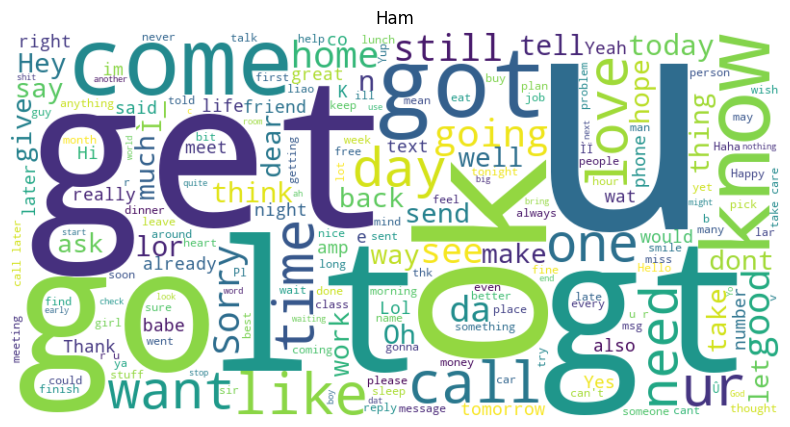

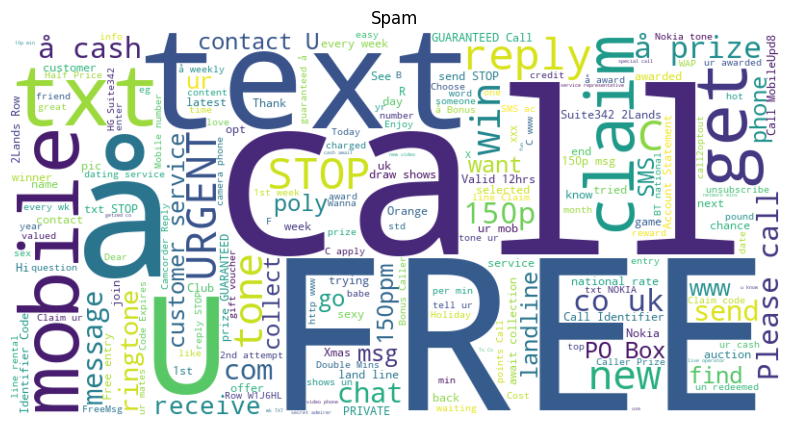

In [9]:
def plot_wordcloud(label):
    text = ' '.join(df[df.label==label]['text'])
    wordcloud = WordCloud(width=800, height=400, stopwords=stop_words, background_color='white').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Spam' if label==1 else 'Ham')
    plt.show()

plot_wordcloud(0)
plot_wordcloud(1)


Step 3: Bag of Words + Model

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# BoW
bow = CountVectorizer(stop_words='english')
X_train_bow = bow.fit_transform(X_train)
X_test_bow = bow.transform(X_test)

model = MultinomialNB()
model.fit(X_train_bow, y_train)
pred_bow = model.predict(X_test_bow)

f1_bow = f1_score(y_test, pred_bow)
print("F1-Score (BoW):", f1_bow)


F1-Score (BoW): 0.9387755102040817


Step 4: TF-IDF + Model

In [11]:
tfidf = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

model.fit(X_train_tfidf, y_train)
pred_tfidf = model.predict(X_test_tfidf)

f1_tfidf = f1_score(y_test, pred_tfidf)
print("F1-Score (TF-IDF):", f1_tfidf)


F1-Score (TF-IDF): 0.8593155893536122


Step 5: Text Preprocessing + TF-IDF + Model

In [12]:
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['clean_text'] = df['text'].apply(preprocess_text)
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(df['clean_text'], df['label'], test_size=0.2, random_state=42)

tfidf_clean = TfidfVectorizer()
X_train_clean_tfidf = tfidf_clean.fit_transform(X_train_clean)
X_test_clean_tfidf = tfidf_clean.transform(X_test_clean)

model.fit(X_train_clean_tfidf, y_train_clean)
pred_clean = model.predict(X_test_clean_tfidf)

f1_clean = f1_score(y_test_clean, pred_clean)
print("F1-Score (TF-IDF + Preprocessing):", f1_clean)


F1-Score (TF-IDF + Preprocessing): 0.8593155893536122


Step 6: Final Summary

In [13]:
summary_df = pd.DataFrame({
    "Method": ["Bag-of-Words", "TF-IDF", "TF-IDF + Preprocessing"],
    "F1-Score": [f1_bow, f1_tfidf, f1_clean]
})

print(summary_df)


                   Method  F1-Score
0            Bag-of-Words  0.938776
1                  TF-IDF  0.859316
2  TF-IDF + Preprocessing  0.859316


Step 7: Add SVM Model for Comparison


We’ll repeat the same three experiments (BoW, TF-IDF, and TF-IDF + preprocessing) using SVM (Support Vector Machine) with a linear kernel and visualize the comparison.

In [14]:
from sklearn.svm import LinearSVC

svm_bow = LinearSVC()
svm_bow.fit(X_train_bow, y_train)
pred_svm_bow = svm_bow.predict(X_test_bow)
f1_svm_bow = f1_score(y_test, pred_svm_bow)
print("F1-Score (SVM + BoW):", f1_svm_bow)


F1-Score (SVM + BoW): 0.9214285714285714


SVM with TF-IDF

In [15]:
svm_tfidf = LinearSVC()
svm_tfidf.fit(X_train_tfidf, y_train)
pred_svm_tfidf = svm_tfidf.predict(X_test_tfidf)
f1_svm_tfidf = f1_score(y_test, pred_svm_tfidf)
print("F1-Score (SVM + TF-IDF):", f1_svm_tfidf)


F1-Score (SVM + TF-IDF): 0.916083916083916


SVM with TF-IDF + Preprocessing

In [16]:
svm_clean = LinearSVC()
svm_clean.fit(X_train_clean_tfidf, y_train_clean)
pred_svm_clean = svm_clean.predict(X_test_clean_tfidf)
f1_svm_clean = f1_score(y_test_clean, pred_svm_clean)
print("F1-Score (SVM + TF-IDF + Preprocessing):", f1_svm_clean)


F1-Score (SVM + TF-IDF + Preprocessing): 0.9110320284697508


Final Results Comparison Table

In [17]:
summary_df = pd.DataFrame({
    "Method": [
        "Naive Bayes + BoW", "Naive Bayes + TF-IDF", "Naive Bayes + TF-IDF + Preprocessing",
        "SVM + BoW", "SVM + TF-IDF", "SVM + TF-IDF + Preprocessing"
    ],
    "F1-Score": [f1_bow, f1_tfidf, f1_clean, f1_svm_bow, f1_svm_tfidf, f1_svm_clean]
})
print(summary_df)


                                 Method  F1-Score
0                     Naive Bayes + BoW  0.938776
1                  Naive Bayes + TF-IDF  0.859316
2  Naive Bayes + TF-IDF + Preprocessing  0.859316
3                             SVM + BoW  0.921429
4                          SVM + TF-IDF  0.916084
5          SVM + TF-IDF + Preprocessing  0.911032


Visualization of Results

C:\Users\jyoti\AppData\Local\Temp\ipykernel_12720\4103624182.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_df.sort_values(by='F1-Score'), x='F1-Score', y='Method', palette="mako")
C:\Users\jyoti\AppData\Local\Temp\ipykernel_12720\4103624182.py:12: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
c:\Program Files\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


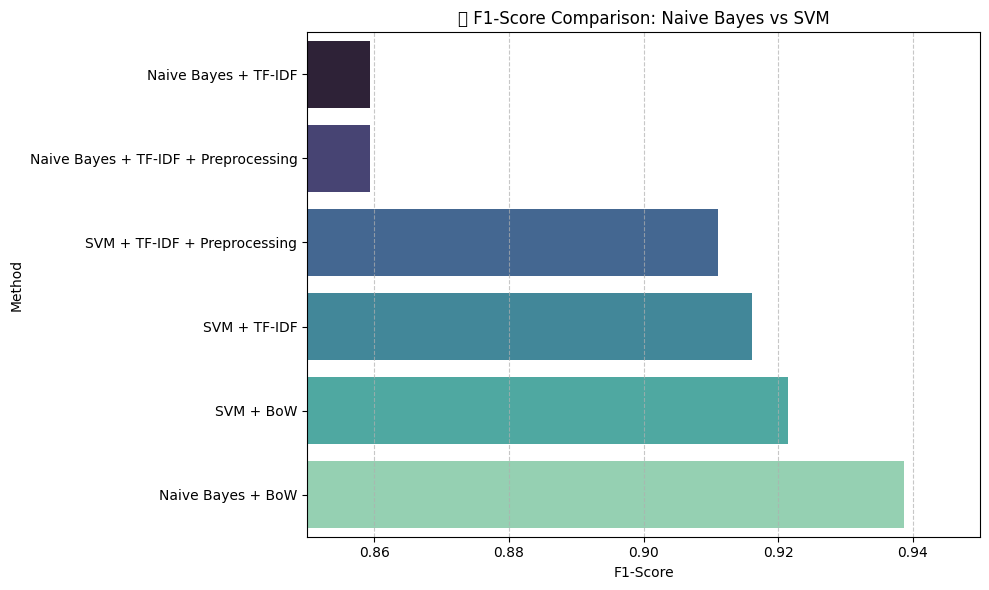

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(10,6))
sns.barplot(data=summary_df.sort_values(by='F1-Score'), x='F1-Score', y='Method', palette="mako")
plt.title("📊 F1-Score Comparison: Naive Bayes vs SVM")
plt.xlabel("F1-Score")
plt.ylabel("Method")
plt.xlim(0.85, 0.95)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In this spam detection study, Naive Bayes paired with Bag-of-Words (BoW) delivered the highest F1-score (0.9388), demonstrating that raw word counts effectively capture strong spam indicators. Notably, using TF-IDF with Naive Bayes led to a nearly 8% drop in F1-score, likely because TF-IDF reduces the impact of frequent terms that are crucial for Naive Bayes’ predictions. Conversely, SVM maintained stable performance across all vectorization techniques, leveraging its strength in handling high-dimensional, sparse representations like those from TF-IDF. Surprisingly, extensive text preprocessing did not significantly enhance results for either model; in fact, excessive cleaning may have stripped away important features, especially since spam often includes deliberately altered terms (such as “Fr33” or “W1n”). Therefore, Naive Bayes with BoW is best suited for fast, lightweight deployment, while SVM with TF-IDF is preferable when robustness and generalization are essential. Overall, combining minimal preprocessing with carefully selected vectorization tends to outperform aggressive text cleaning in spam detection tasks.